# Assignment 3: Universal Function Approximator


The goal of this exercise is to train a two-layer fully-connected network to perform one-dimensional non-linear regression via gradient descent. To show the flexibility of the approach, three different functions will be approximated. First, the network and its gradient need to be implemented. Second, target data for three different functions will be generated. Finally, the training procedure will be applied to the data, and the resulting approximated function will be plotted together with the data samples.

## Network Implementation

A two-layer network is defined by parameters $\Theta=(\mathbf W^{(1)},\vec w^{(2)})$ that are split into $\mathbf W^{(1)}\in\mathbb R^{K\times {(D+1)}}$ for the first layer and $\vec w^{(2)}\in\mathbb R^{K+1}$ for the second layer. In our case, since we have only a single input, we have $D=1$.
For a given input $\vec x = (1, x)^T$, the network is implemented in three steps:

1. Compute the first layer output, aka, the activation: $\vec a_- = \mathbf W^{(1)} \vec x$
2. Apply the activation function for each element of $\vec a_- : \vec h_- = g(\vec a_-)$ and prepend the bias neuron $h_0=1$ to arrive at $\vec h$.
3. Compute the output of the network: $y = \vec w^{(2)}\ ^T\vec h$.

### Task 1  
Implement a function that returns the network output for a given input $\vec x$ and parameters $\Theta=(\mathbf W^{(1)}, \vec w^{(2)})$. Remember that the input of the function $\vec x = (1, x)^T$. Also remember to prepend $h_0=1$ in your implementation.

We use hyperbolic tangent $(\tanh)$ as the activation function:

\begin{equation*}
    \tanh(a) = \frac{e^{a}-e^{-a}}{e^{a}+e^{-a}}
\end{equation*}

Note:

1. Use the `numpy` implemention of the hyperbolic tangent function.
2. Use `numpy.concatenate` or `numpy.insert` to prepend $h_0$.
3. Make use of `numpy.dot` to compute matrix-vector and vector-vector products.

In [ ]:
import numpy
import math

def network(x, Theta):
  W1, w2 = Theta
  a_ = numpy.dot(W1, x)
  h_ = numpy.tanh(a_)
  h = numpy.insert(h_, 0, [1])
  y = numpy.dot(w2, h)
  return y, h

Test 1: Sanity Check
----------------------------

We select a specific number of hidden neurons and create the weights accordingly, using all zeros in the first layer and all ones in the second. The test case below assures that the function from Task 1 actually returns $1$ for those weights.

Note: your function should pass the test below.

In [ ]:
K = 20
D = 1
W1 = numpy.zeros((K, D+1))
w2 = numpy.ones(K+1)
x = numpy.random.rand(D+1)

y, _ = network(x, (W1, w2))
assert abs(1 - y) < 1e-6
print("Test passed")

Test passed


## Gradient Implementation

In order to perform gradient descent, we need to define a loss function. As provided in the lecture, the $\mathcal J^{L_2}$ loss function is defined over a dataset $X=\{(\vec x^{[n]}, t^{[n]})\}$, that is defined as a list of tuples, as follows:

$$
   \mathcal J^{L_2} = \frac{1}{N}\sum_{i=1}^N (y^{[n]}-t^{[n]})^2
$$

where $y^{[n]}$ is the output of the network from Task 1 when inputting $\vec x^{[n]}$. Interestingly, however, we never explicitly need to compute the output of the loss function. It is only used to analytically compute the gradient as shown in the lecture.

The gradient is composed of two items, one for each layer. Particularly, for a given dataset $X$, the gradient of loss $J^{L_2}$ is defined as:

\begin{align}
  \frac{\partial \mathcal J}{\partial w_{kd}^{(1)}} &= \frac{2}{N} \sum\limits_{n=1}^N (y^{[n]}-t^{[n]}) w_{k}^{(2)} (1-h_{k}^{[n]}\cdot h_{k}^{[n]}) x_{d}^{[n]}\\
  \frac{\partial \mathcal J}{\partial w_{k}^{(2)}} &= \frac{2}{N} \sum\limits_{n=1}^N (y^{[n]}-t^{[n]}) w_{k}^{(2)} h_{k}^{[n]}
\end{align}

### Task 2
Implement a function that returns the gradient as defined in $(1)$ and $(2)$ for a given dataset $X$, and given weights $\Theta=(\mathbf W^{(1)},\vec w^{(2)})$. Make sure that both parts of the gradient are computed. 

Hint:

1. Make use of the the function implemented in Task 1 where appropriate

Note:

  1. This is a slow implementation. We will see how to speed this up in the next lecture.
  2. You can make use of `numpy.zeros` to initialize the gradient.
  3. The outper product can be computed via `numpy.outer`.
  4. Remember that we used the $\tanh$ activation function in our network.

In [ ]:
def gradient(X, Theta):
  # split parameters for easier handling
  W1, w2 = Theta
  
  N = len(X)
  # define gradient with respect to both parameters
  dW1 = numpy.zeros((W1.shape[0]+1, W1.shape[1]))
  dW2 = numpy.zeros(w2.shape)

  # iterate over dataset
  for x, t in X:
    y, h = network(x, Theta)
    # compute the gradient
    dW1 = dW1 + numpy.outer((y-t)*w2*(1-h*h),x)
    dW2 = dW2 + (y-t)*w2*h
    
  # anything else?
  dW1 = dW1 * 2/N
  dW2 = dW2 * 2/N
  dW1 = dW1[1:]
  
  return dW1, dW2

## Gradient Descent

The procedure of gradient descent is the repeated application of two steps.
 
1. The gradient of loss $\nabla_{\Theta}\mathcal J^{L_2}$ is computed based on the current value of the parameters $\Theta=(\mathbf W^{(1)},\vec w^{(2)})$.
2. The weights are updated by moving a small step $\eta$ into the direction of the negative gradient:

$$
    \Theta = \Theta - \eta \nabla_{\Theta}\mathcal J
$$

As stopping criterion, we select the number of training epochs to be 10000.

### Task 3
Implement a function that performs gradient descent for a given dataset $X$, given initial parameters $\Theta$ and a given learning rate $\eta$ and returns the optimized parameters $\Theta^*$.

In [ ]:
def gradient_descent(X, Theta, eta):
  epochs = 10000
  w1, w2 = Theta
  # perform iterative gradient descent
  for epoch in range(epochs):
    # compute the gradient
    dw1, dw2 = gradient(X, Theta)

    # update the parameters
    w1 = w1 - eta*dw1
    w2 = w2 - eta*dw2

  # return optimized parameters
  return (w1, w2)

## Generate Datasets

In total, we will test our gradient descent function with three different datasets. Particularly, we approximate:

1. $X_1: t = \sin(2x)$ for $x\in[-2,2]$
2. $X_2: t = e^{-2x^2}$ for $x\in[-2,2]$
3. $X_3: t = -x^5 - 3x^4 + 11x^3 + 27x^2 - 10x - 64$ for $x\in[-4.5,3.5]$

### Task 4

Generate dataset $X_1$, for $N=50$ samples randomly drawn from range $x\in[-2,2]$. 
Generate data $X_2$ for $N=30$ samples randomly drawn from range $x\in[-2,2]$. 
Generate dataset $X_3$ for $N=200$ samples randomly drawn from range $x\in[-4.5,3.5]$. 
Implement all three datasets as lists of tuples: $\{(\vec x^{[n]}, t^{[n]})\mid 1\leq n\leq N\}$.

Note:

  1. You can use `numpy.random.uniform` to create uniformly distributed samples for $x$.
  2. Make sure that $\vec x = (1, x)^T$ for each sample.
  3. You can make use of `numpy.sin`, `numpy.exp` and `numpy.pow` to compute target values.

In [ ]:
X1 = [(numpy.array([1, x]), numpy.sin(2*x)) for x in numpy.random.uniform(low=-2,high=2,size=50)]
X2 = [(numpy.array([1, x]), numpy.exp(-2*x**2)) for x in numpy.random.uniform(low=-2,high=2,size=30)]
X3 = [(numpy.array([1, x]), (-numpy.power(x, 5)-3*numpy.power(x, 4)+11*numpy.power(x, 3)+27*numpy.power(x, 2)-10*x-64)) for x in numpy.random.uniform(low=-4.5,high=3.5,size=200)]


### Test 2: Sanity Check

The test case below assures that the elements of each generated dataset are tuples with two elements, that the first element ($\vec x$) is a vector with two numbers, and that the second element ($t$) is a float.

In [ ]:
assert all(
    isinstance(x, (tuple,list)) and 
    len(x) == 2 and 
    isinstance(x[0], (tuple,list,numpy.ndarray)) and 
    len(x[0] == 2) and 
    isinstance(x[1], float)
    for X in (X1, X2, X3)
    for x in X
)

print('Test passed!')

Test passed!


## Function Approximation

Finally, we want to make use of our gradient descent implementation to approximate our functions. In order to see our success, we want to plot the functions together with the data.

### Task 5 (theoretical question)

When looking at the example plots in the exercise slides (exemplary solutions for the plotting Task 8), how many hidden neurons $K$ do we need in order to approximate the functions? Is there any difference
1 between the three target functions?

**Answer: Number of hidden neurons based on exercise slides are 3,2, and 5**


In [ ]:
K1 = 6 
K2 = 6 
K3 = 20 

### Task 6

For each of the datasets, randomly initialize the parameters $\Theta_1,\Theta_2,\Theta_3\in[-1,1]$ according to the number of hidden neurons estimated in Task 5.

Note:

  1. You can use `numpy.random.uniform` to initialize the weights.
  2. Make sure that the weight matrices are instantiated in the correct dimensions.

In [ ]:
Theta1 = (numpy.random.uniform(low=-1, high=1, size=(K1, D+1)), numpy.random.uniform(low=-1, high=1, size=K1+1))
Theta2 = (numpy.random.uniform(low=-1, high=1, size=(K2, D+1)), numpy.random.uniform(low=-1, high=1, size=K2+1))
Theta3 = (numpy.random.uniform(low=-1, high=1, size=(K3, D+1)), numpy.random.uniform(low=-1, high=1, size=K3+1))

### Task 7

Call gradient descent function from Task 3 using the datasets $X_1, X_2, X_3$, the according created parameters $\Theta_1,\Theta_2,\Theta_3$ and a learning rate of $\eta=0.1$. Store the resulting optimized weights $\Theta_1^*, \Theta_2^*, \Theta_3^*$ and the loss values.

Optimize the learning rate $\eta$ for each of the three functions. Do you see any differences? What are the best learning rates that you can find?
**Answer: We see lot of difference in the plots in Task 9 while changing learning rates. We experimented with different learning rates and so far eta = 0.00005 is optimal.**

WARNING: Depending on the implementation, this might run for several minutes!

In [ ]:
#eta = 0.1
#Theta1_star = gradient_descent(X1, Theta1, eta)
#Theta2_star = gradient_descent(X2, Theta2, eta)
#Theta3_star = gradient_descent(X3, Theta3, eta)

# optimised learning rate 
Theta1_star = gradient_descent(X1, Theta1, 0.000005)
Theta2_star = gradient_descent(X2, Theta2, 0.00005)
Theta3_star = gradient_descent(X3, Theta3, 0.00005)

## Data and Function Plotting

### Task 8

Implement a plotting function that takes a given dataset $X$, given parameters $\Theta$ and a defined range $R$. Each data sample $(x^{[n]},t^{[n]})$ of the dataset is plotted as an $''x''$. In order to plot the function that is approximated by the network, generate sufficient equally-spaced input values $x\in R$, compute the network output $y$ for these inputs, and plot them with a line.

Note:

  1. The dataset $X$ is defined as above, a list of tuples $(\vec x, t)$.
  2. Each input in the dataset is defined as $\vec x = (1,x)^T$.
  3. Equidistant points can be obtained via `numpy.arange`.

In [ ]:
from matplotlib import pyplot

def plot(X, Theta, R):
  # first, plot data samples
  pyplot.plot([x[0][1] for x in X], [x[1] for x in X], "rx", label="Data")

  # define equidistant points from R[0] to R[1] to evaluate the network
  x = numpy.arange(start=R[0], stop=R[1], step=0.1)
  # compute the network outputs for these values
  y = [network(numpy.array([1, xx]), Theta)[0] for xx in x]
  # plot network approximation
  pyplot.plot(x,y,"k-", label="network")
  pyplot.legend()

### Task 9

For each of the datasets and their according optimized parameters, call the plotting function from Task 8. Use range $R=[-3,3]$ for dataset $X_1$ and $X_2$, and range $R=[-5.5,4.5]$ for dataset $X_3$. Note that the first element of range $R$ should be the lowest $x$-location, and the second element of $R$ the highest value for $x$. Did the networks approximate the functions? What can we do if not?

Answer: The network did not approximate the function. Following are the things which can be done to approximate better:
1. Increase the number of neurons used per layer, so that network will be able to learn more complex relationships between the data.
2. Optimize learning rate, so the convergence of training process can be improved
3. Instead of using epoch to optimize weights, terminate when loss is minimum

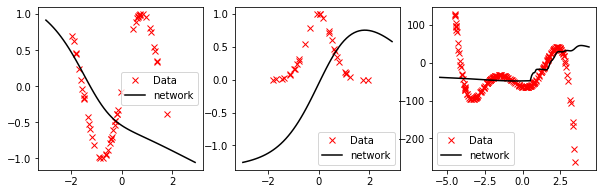

In [ ]:
figure = pyplot.figure(figsize=(10,3))

# plot first function
pyplot.subplot(131)
plot(X1, Theta1_star, [-3, 3])

# plot second function
pyplot.subplot(132)
plot(X2, Theta2_star, [-3, 3])

# plot third function
pyplot.subplot(133)
plot(X3, Theta3_star, [-5.5, 4.5])